# Step 1: Retrieve NFkB interacting proteins from UniProt API

In [2]:
import requests
def get_nfkb_interactors(accession=""):
    # url = "https://www.ebi.ac.uk/proteins/api/proteins/interaction"
    url = f"https://rest.uniprot.org/uniprotkb/search?query=accession:{accession}&fields=cc_interaction"
    # Uniprot collects data from multiple sources, including IntAct, MINT, STRING, etc.
    # "P19838" refers to the protein entry for the "Nuclear factor NF-kappa-B p105 subunit" (NFKB1). We collect interactions
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    
    data = response.json()
    genes = set()

    for result in data.get("results", []):
        for comment in result.get("comments", []):
            if comment["commentType"] == "INTERACTION":
                for interaction in comment["interactions"]:
                    # Get interactantTwo details
                    interactant_two = interaction["interactantTwo"]
                    if "geneName" in interactant_two:
                        # Add gene name if it's not self-interaction
                        if interactant_two["uniProtKBAccession"] != accession:
                            genes.add(interactant_two["geneName"])

    return list(genes)

# Get ineracting genes
nfkb_interactors = get_nfkb_interactors("P19838") #NF-kB1(p50) (Class 1)
print(f"Found {len(nfkb_interactors)} interacting genes")
print(nfkb_interactors)

Found 24 interacting genes
['MEN1', 'PDCD11', 'RELA', 'PLD3', 'RELB', 'HTT', 'HIF1AN', 'UL42', 'PELP1', 'NFKB2', 'TNIP1', 'ESR1', 'NOTCH1', 'TNIP2', 'MAP3K8', 'CHUK', 'COPB2', 'RPS3', 'NFKBIB', 'CTNNB1', 'HDAC1', 'ABCC2', 'NFKBIA', 'IKBKB']


# Step 2: Perform pathway enrichment analysis using gProfiler

In [1]:
import gprofiler
import pandas
gp = gprofiler.GProfiler(return_dataframe=True)
enrichment_results = gp.profile(
    organism='hsapiens',
    query=nfkb_interactors,
    sources=['KEGG', 'REACTOME'],
    user_threshold=0.05,
    significance_threshold_method='fdr',
    domain_scope='annotated'
)
enrichment_results.to_csv('nfkb_pathway_enrichment.csv', index=False)
print(enrichment_results[['source', 'name', 'p_value', 'intersection_size']].head())

NameError: name 'nfkb_interactors' is not defined

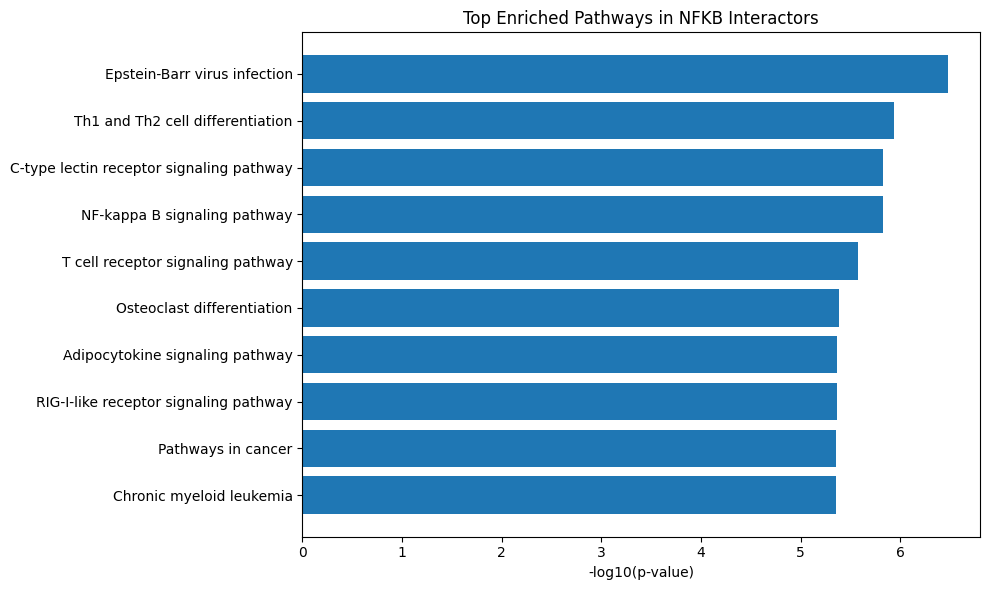

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_graph(enrichment_results):
    # Filter and sort results
    # p-value < 0.05 means those pathways where there is less than 5% chance that the overlap between the input gene list and the pathway is due to random chance
    significant = enrichment_results[enrichment_results['p_value'] < 0.05]
    significant = significant.sort_values('p_value').head(10)

    if significant.empty:
        print("No significant pathway found")

    else:
        # Create plot
        plt.figure(figsize=(10, 6))
        plt.barh(significant['name'], -np.log10(significant['p_value']))
        plt.xlabel('-log10(p-value)')
        plt.title("Top Biological Processes in NFKB Interactors")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    
plot_graph(enrichment_results)

# There are 4 more sub units for NF-kB. Let's find the top enriched pathways for interacting genes in those

In [ ]:
# Get interacting genes for subunit 2
nfkb_interactors_subunit2 = get_nfkb_interactors("Q00653") #NF-kB2 (p52) (Class 1)
print(f"Found {len(nfkb_interactors_subunit2)} interacting genes")
print(nfkb_interactors_subunit2)

Found 8 interacting genes
['SUMO1', 'MEN1', 'NFKBIA', 'RELB', 'REL', 'MAP3K8', 'NFKBIB', 'NFKB1']


In [ ]:
enrichment_results_subunit2 = gp.profile(
    organism='hsapiens',
    query=nfkb_interactors_subunit2,
    sources=['KEGG', 'REACTOME'],
    user_threshold=0.05,
    significance_threshold_method='fdr',
    domain_scope='annotated'
)
# enrichment_results_subunit2.to_csv('nfkb2_pathway_enrichment.csv', index=False)
print(enrichment_results_subunit2[['source', 'name', 'p_value', 'intersection_size']].head())

  source                                   name   p_value  intersection_size
0   KEGG      T cell receptor signaling pathway  0.000195                  4
1   KEGG  RIG-I-like receptor signaling pathway  0.000503                  3
2   KEGG        Adipocytokine signaling pathway  0.000503                  3
3   KEGG                          Leishmaniasis  0.000503                  3
4   KEGG           Epstein-Barr virus infection  0.000503                  4


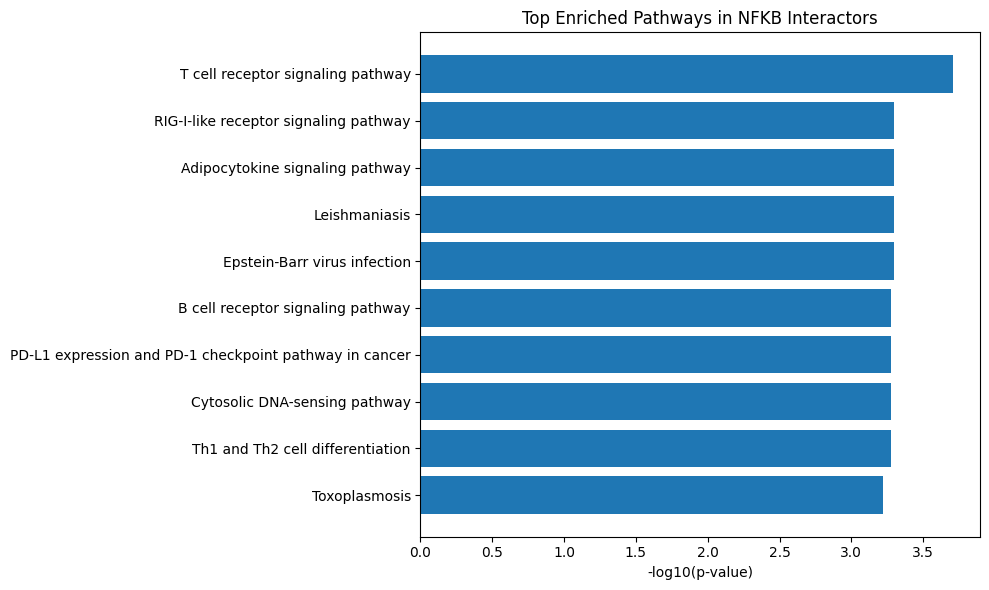

In [ ]:
plot_graph(enrichment_results_subunit2)

In [ ]:
# Get interacting genes for subunit 3
nfkb_interactors_subunit3 = get_nfkb_interactors("Q04206") #RELA_P65_HUMAN (Class 2)
print(f"Found {len(nfkb_interactors_subunit3)} interacting genes")
print(nfkb_interactors_subunit3)

Found 78 interacting genes
['IRF5', 'NR4A1', 'YPO3877', 'BRD4', 'NFKBIA', 'ESR1', 'nleC', 'CREBBP', 'OGT', 'SIRT2', 'PIAS4', 'EHMT1', 'CDK5RAP3', 'DHX9', 'ATF3', 'UXT', 'NFKBIE', 'SIRT6', 'PDCD4', 'LAMP2', 'NSD1', 'YPO2940', 'SETD7', 'KDM2A', 'CDK5RAP2', 'NFKBIB', 'Myocd', 'MACROD1', 'PRPF40A', 'STAT3', 'sctL', 'SNAI1', 'Brd4', 'SOCS1', 'SIX2', 'COMMD1', 'P/V', 'OTT_0753', 'CHUK', 'GAMMAHV.ORF73', 'DAXX', 'IKBKB', 'KEAP1', 'UBC', 'CASP6', 'LMO2', 'PPP2CA', 'TGM2', 'RAN', 'CHAT', 'MAPK10', 'FGFR3', 'TP53BP2', 'UL42', 'BANF1', 'UBQLN1', 'FUS', 'HDAC1', 'NFE2L2', 'GSN', 'IER3', 'SIRT1', 'MEN1', 'RPS3', 'KLF6', 'CCK', 'OTT_1912', 'GFI1', 'REL', 'CRIP2', 'CTNNB1', 'NFKB1', 'PPP2R1A', 'yerA', 'RELB', 'TARDBP', 'TCF4', 'AATF']


In [ ]:
enrichment_results_subunit3 = gp.profile(
    organism='hsapiens',
    query=nfkb_interactors_subunit3,
    sources=['KEGG', 'REACTOME'],
    user_threshold=0.05,
    significance_threshold_method='fdr',
    domain_scope='annotated'
)
print(enrichment_results_subunit3[['source','name','p_value','intersection_size']].head())

  source                               name       p_value  intersection_size
0   KEGG    Adipocytokine signaling pathway  9.988480e-07                  8
1   KEGG  T cell receptor signaling pathway  2.060417e-06                  9
2   KEGG       Epstein-Barr virus infection  6.294749e-06                 10
3   KEGG                      Toxoplasmosis  6.294749e-06                  8
4   KEGG          Th17 cell differentiation  6.294749e-06                  8


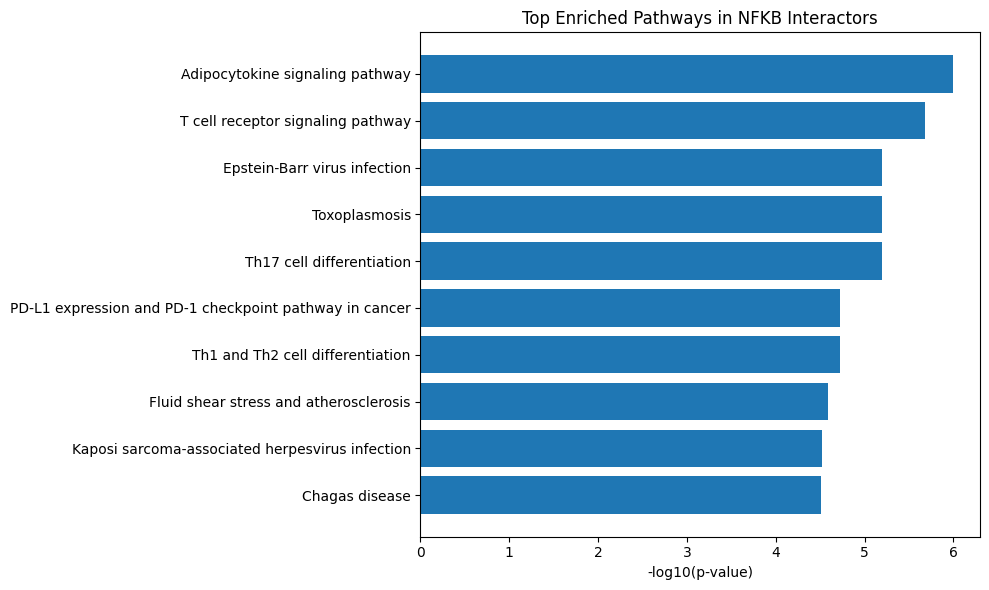

In [ ]:
plot_graph(enrichment_results_subunit3)

In [ ]:
# Get interacting genes for subunit 4
nfkb_interactors_subunit4 = get_nfkb_interactors("Q04864") #cRel_HUMAN (Class 2)
print(f"Found {len(nfkb_interactors_subunit4)} interacting genes")
print(nfkb_interactors_subunit4)

Found 281 interacting genes
['DNTT', 'IL36RN', 'TSC22D3', 'DYNC1LI1', 'GRB2', 'MORF4L2', 'FNDC11', 'NUDT14', 'ARMC7', 'ASMTL', 'CDKN1A', 'NGB', 'ATP6V0D2', 'ESRRG', 'CDK18', 'CFAP206', 'TTC21A', 'CPSF1', 'OAZ3', 'POLR2L', 'MMP2', 'PELI2', 'ZNF688', 'DDX6', 'EFHC1', 'TSTD2', 'NR2C2AP', 'PAK1IP1', 'SAMD11', 'YARS', 'NFKBIA', 'KCTD7', 'NMRK1', 'SIX1', 'TNS2', 'FAAP20', 'TRIM68', 'EPM2AIP1', 'UBE2D4', 'CHIC2', 'CCNJL', 'PLCB4', 'RNF6', 'AIRIM', 'CHCHD2', 'RAB41', 'CINP', 'SEC14L4', 'EIF5A', 'NFKB2', 'L3MBTL2', 'CKS1B', 'FKBP1B', 'MAD2L2', 'TNIP2', 'MAPRE3', 'PRPF31', 'ZIC1', 'TRIM74', 'MTURN', 'ACOT8', 'CDKN2D', 'HAT1', 'TBC1D21', 'DHPS', 'SAT1', 'NABP1', 'NFKBIE', 'NCK2', 'SLC39A13', 'HIP1', 'SHC3', 'NEIL2', 'POLE2', 'EXOSC1', 'MRPL10', 'AKT2', 'NECAP1', 'ASAP3', 'NEDD9', 'PSMB8', 'MYO15B', 'TSSC4', 'LASP1', 'LSM2', 'STAMBPL1', 'CTNNBIP1', 'HDAC7', 'MORF4L1', 'FLNA', 'NXT2', 'FOXO4', 'CYB5R2', 'SZT2', 'SNRNP25', 'PSMA4', 'RAB29', 'SLC41A3', 'EXOSC8', 'HNRNPF', 'SULT2B1', 'NFKBIB', 'PTGER3

In [ ]:
enrichment_results_subunit4 = gp.profile(
    organism='hsapiens',
    query=nfkb_interactors_subunit4,
    sources=['KEGG', 'REACTOME'],
    user_threshold=0.05,
    significance_threshold_method='fdr',
    domain_scope='annotated'   
)
print(enrichment_results_subunit4[['source','name','p_value','intersection_size']].head())

  source                             name   p_value  intersection_size
0   KEGG           FoxO signaling pathway  0.011338                  9
1   KEGG  Adipocytokine signaling pathway  0.011338                  7
2   KEGG         Chronic myeloid leukemia  0.011338                  7
3   KEGG     Epstein-Barr virus infection  0.025540                 10
4   KEGG               Pathways in cancer  0.025540                 18


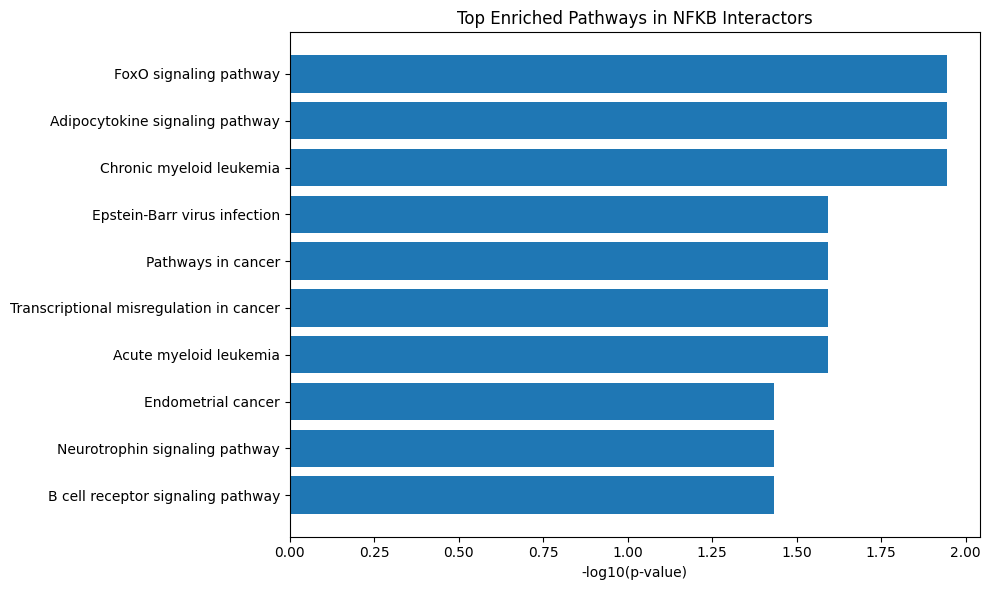

In [ ]:
plot_graph(enrichment_results_subunit4)

In [ ]:
# Get interacting genes for subunit 5
nfkb_interactors_subunit5 = get_nfkb_interactors("Q01201") #Re1B_HUMAN (Class 2)
print(f"Found {len(nfkb_interactors_subunit5)} interacting genes")
print(nfkb_interactors_subunit5)

Found 6 interacting genes
['RELA', 'NFKB2', 'SMARCC1', 'GSK3B', 'COMMD1', 'NFKB1']


In [ ]:
enrichment_results_subunit5 = gp.profile(
    organism='hsapiens',
    query=nfkb_interactors_subunit5,
    sources=['KEGG', 'REACTOME'],
    user_threshold=0.05,
    significance_threshold_method='fdr',
    domain_scope='annotated'   
)
print(enrichment_results_subunit5[['source','name','p_value','intersection_size']].head())

  source                          name   p_value  intersection_size
0   KEGG               Prostate cancer  0.000254                  3
1   KEGG   Prolactin signaling pathway  0.000254                  3
2   KEGG            Insulin resistance  0.000254                  3
3   KEGG  NF-kappa B signaling pathway  0.000254                  3
4   KEGG       IL-17 signaling pathway  0.000254                  3


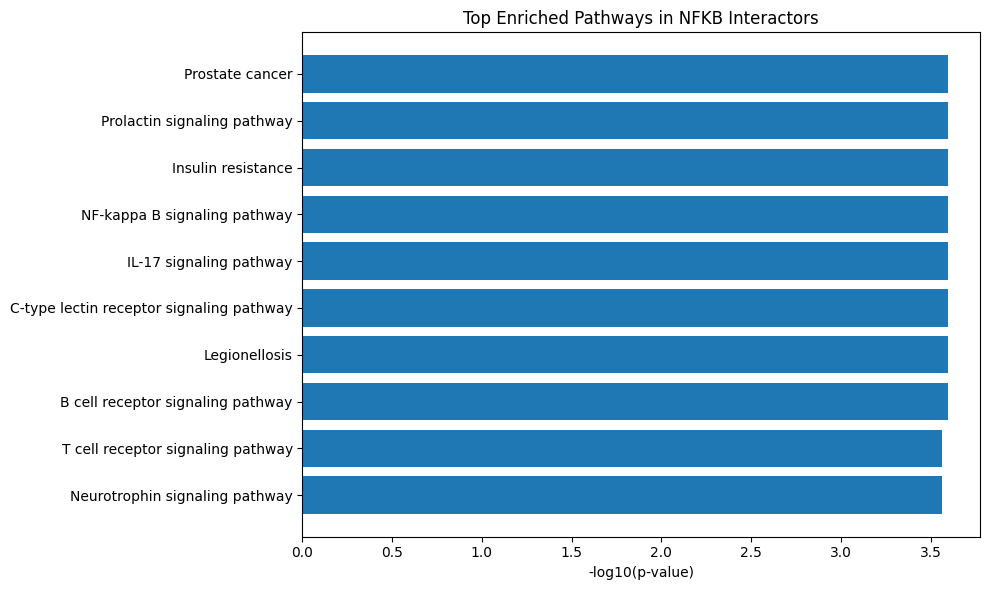

In [ ]:
plot_graph(enrichment_results_subunit5)

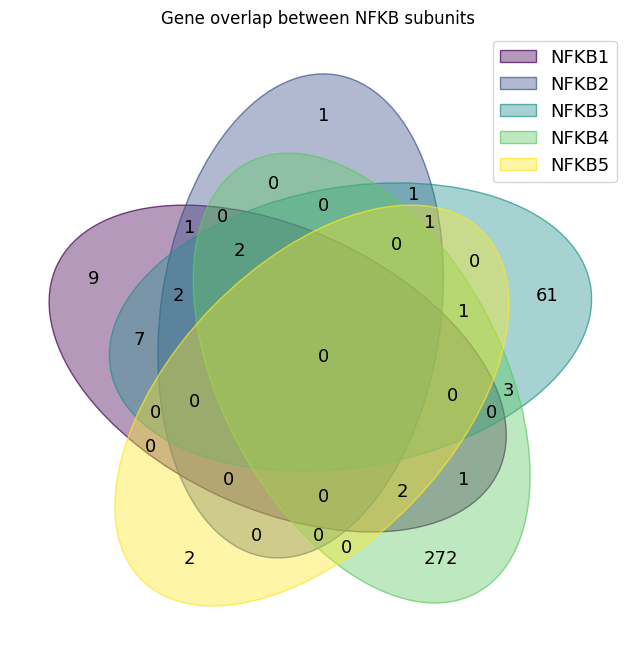

In [ ]:
# Venn diagram for common genes in all subunits
from venn import venn
import matplotlib.pyplot as plt

# Define your sets
sets = {
    "NFKB1": set(nfkb_interactors),
    "NFKB2": set(nfkb_interactors_subunit2),
    "NFKB3": set(nfkb_interactors_subunit3),
    "NFKB4": set(nfkb_interactors_subunit4),
    "NFKB5": set(nfkb_interactors_subunit5)
}

# Plot the Venn.diagram
venn(sets)
plt.title("Gene overlap between NFKB subunits")

plt.show()


In [ ]:
def find_common_pathways(dataframe_list, top_n=10):
    # Get top pathways from each Dataframe
    top_pathways_sets = []
    for df in dataframe_list:
        top_names = df.head(top_n)['name'].tolist() # Get top_n in each DataFrame, then get the 'name' column and convert to list
        top_pathways_sets.append(set(top_names)) # Convert list to set and append to top_pathways_sets

    # Find common pathways
    # * unpacks the list into separate arguments
    # eg: if top_pathway_sets = [{1, 2, 3}, {2, 3, 4}, {3, 4, 5}], then 
    # set.intersection(*top_pathway_sets) is equivalent to set.intersection({1, 2, 3}, {2, 3, 4}, {3, 4, 5})
    common_names = set.intersection(*top_pathways_sets)
    return common_names

    # Get complete rows for common pathways from the first DataFrame
    # (assuming all DataFrames have the same structure for these pathways)
    # result_df = dataframe_list[0][dataframe_list[0]['name'].isin(common_names)]
    df = dataframe_list[0]
    result_df = df.query("name in @common_names")


    # Sort by name for consistency 
    return result_df.sort_values('name').reset_index(drop=True)

# Find and display common pathways
all_results = [enrichment_results, enrichment_results_subunit2, enrichment_results_subunit3, enrichment_results_subunit4, enrichment_results_subunit5]
common_pathways = find_common_pathways(all_results, top_n=100)
print(f"Found {len(common_pathways)} common pathways: ")
for p in common_pathways:
    print(f'-{p}')

Found 9 common pathways: 
-Adipocytokine signaling pathway
-Epstein-Barr virus infection
-T cell receptor signaling pathway
-Neurotrophin signaling pathway
-Transcriptional misregulation in cancer
-B cell receptor signaling pathway
-PD-L1 expression and PD-1 checkpoint pathway in cancer
-Chronic myeloid leukemia
-Small cell lung cancer
